In [179]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rescale

In [180]:
def show(img, cmap=None):
  if cmap is not None:
    plt.imshow(img, cmap=cmap)
  else:
    plt.imshow(img)
  plt.show()

In [291]:
coin_image = cv.imread('coins/coins_7.jpg')
coin_image = cv.cvtColor(coin_image, cv.COLOR_BGR2RGB)
# coin_image = np.uint8(rescale(coin_image, (0.25,0.25,1))*255)

In [182]:
np.max(coin_image), np.min(coin_image)

(251, 0)

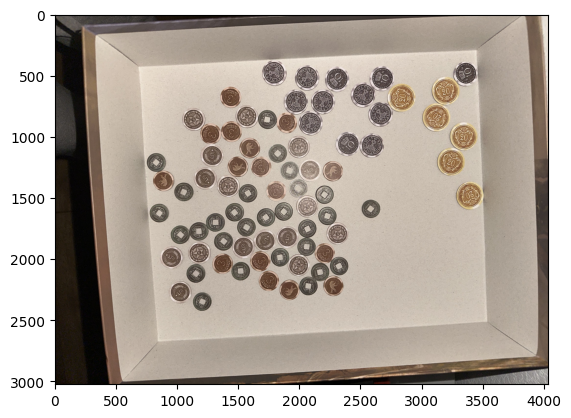

In [292]:
show(coin_image)

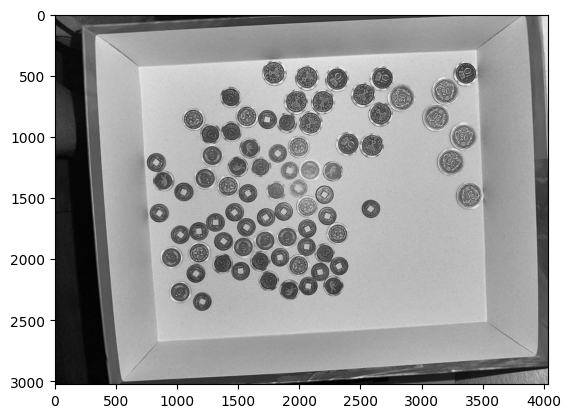

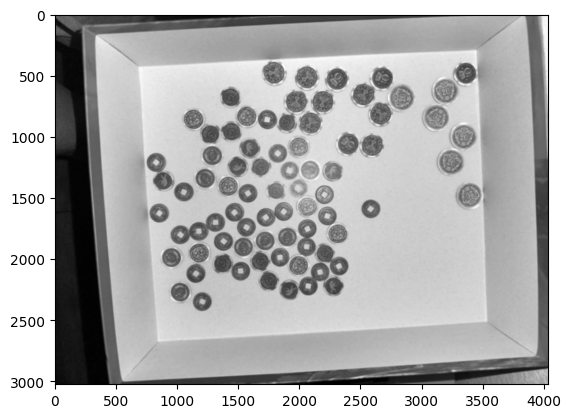

In [296]:
gray = cv.cvtColor(coin_image, cv.COLOR_BGR2GRAY)
show(gray,cmap='gray')
blurred = cv.GaussianBlur(gray, ksize=(25,25),sigmaX=0,sigmaY=0)

show(blurred,cmap='gray')
# edges = cv.Canny(blurred, )

In [185]:
# thresholded = cv.adaptiveThreshold(blurred,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv.THRESH_BINARY,21,5)
# show(thresholded,cmap='gray')



In [186]:
# kernel = np.array([[0,1,0],
#                    [1,1,1],
#                    [0,1,0]], dtype=np.uint8)
# # kernel = np.ones((3,3), dtype=np.uint8)
# closed = cv.morphologyEx(thresholded, cv.MORPH_DILATE, kernel)
# show(closed,cmap='gray')

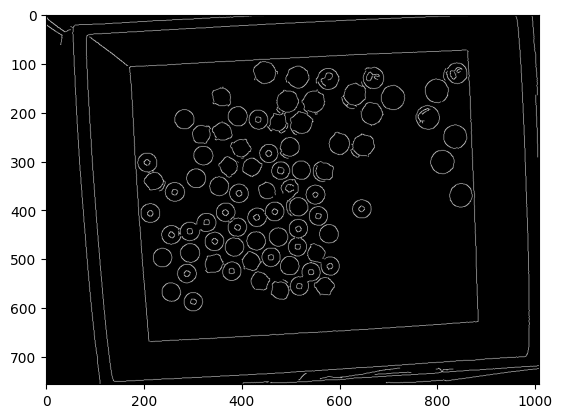

In [307]:
coin_image_downsampled = np.uint8(rescale(coin_image, (0.25,0.25,1))*255)

gray = cv.cvtColor(coin_image_downsampled, cv.COLOR_RGB2GRAY)
blurred = cv.GaussianBlur(gray, ksize=(11,11),sigmaX=0,sigmaY=0)
edges = cv.Canny(blurred, 15, 120)
show(edges,cmap='gray')
contours, hierarchy = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
coin_image_cont = coin_image_downsampled.copy()
# cv.drawContours(coin_image_cont, contours, -1, (0,255,0), 5)

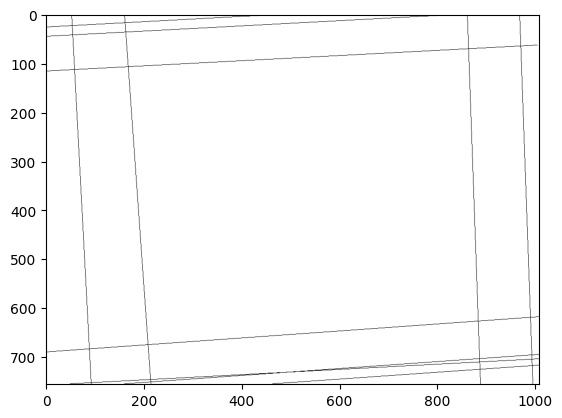

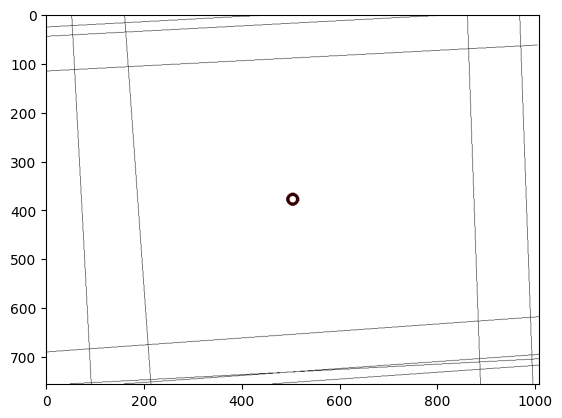

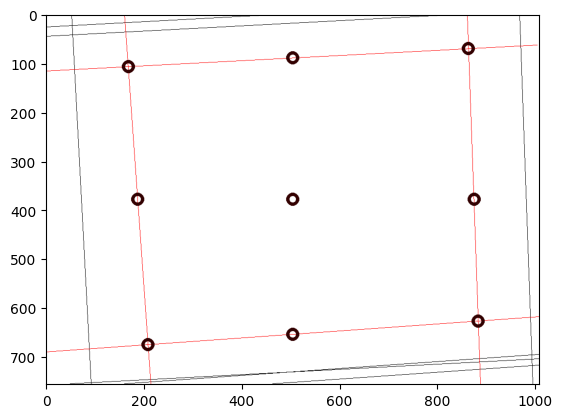

In [309]:
coin_image_lines = coin_image_downsampled.copy()
empty_image = np.ones_like(coin_image_downsampled, dtype=np.uint8)*255
lines = cv.HoughLines(edges,1,np.pi/180,200)
lines_abc = []
lines_xy = []
inner_lines = {}
for line in lines:
   rho,theta=line[0]
   # rho = x*cos(theta)+ y*sin(theta)
   # a*x + b*y +c = 0 -> a=cos, b=sin, c=-rho
   a=np.cos(theta)
   b=np.sin(theta)
   c = -rho
   x0=a*rho
   y0=b*rho
   lines_abc.append((a,b,c))
   x1 = int(x0+1000*(-b))
   y1 = int(y0+1000*(a))
   x2 = int(x0-1000*(-b))
   y2 = int(y0-1000*(a))
   lines_xy.append([(x1,y1),(x2,y2)])
   cv.line(empty_image,(x1,y1),(x2,y2),(0,0,0),1)
show(empty_image)

width = empty_image.shape[1]
height = empty_image.shape[0]
center_x, center_y = int(width/2),int(height/2)
cv.circle(empty_image,(center_x, center_y),10,50,5)
show(empty_image)
def find_and_show_intersection(x,y, show=False):
    intersected_line_idx = np.argmin([abs(a*x+b*y+c) for (a,b,c) in lines_abc])
    (x1,y1),(x2,y2) = lines_xy[intersected_line_idx]
    cv.line(empty_image,(x1,y1),(x2,y2),(255,0,0),1)
    cv.circle(empty_image,(x, y),10,50,5)
    if show:
        show(empty_image)
    return intersected_line_idx

for x in range(center_x,width):
    if all(empty_image[center_y,x]== (0,0,0)):
        #a*x+b*y+c=0
        idx = find_and_show_intersection(x,center_y)
        inner_lines['right'] = idx
        break
for x in range(center_x,0,-1):
    if all(empty_image[center_y,x]== (0,0,0)):
        #a*x+b*y+c=0
        idx = find_and_show_intersection(x,center_y)
        inner_lines['left'] = idx
        break
for y in range(center_y,height):
    if all(empty_image[y,center_x]== (0,0,0)):
        #a*x+b*y+c=0
        idx = find_and_show_intersection(center_x,y)
        inner_lines['up'] = idx
        break
for y in range(center_y,0,-1):
    if all(empty_image[y,center_x]== (0,0,0)):
        #a*x+b*y+c=0
        idx = find_and_show_intersection(center_x,y)
        inner_lines['down'] = idx
        break

def intersetion(idx1, idx2, draw=False, show=False):
    # a1*x+b1*y+c1=0
    # a2*x+b2*y+c2=0
    assert idx1 != idx2
    a1,b1,c1 = lines_abc[idx1]
    a2,b2,c2 = lines_abc[idx2]
    assert (b1*a2-b2*a1) != 0, f'{a1=},{a2=},{b1=},{b2=}'
    assert a1 !=0
    y = int((c2*a1-c1*a2) / (b1*a2-b2*a1))
    x = int(-(c1+b1*y) / a1)
    if draw:
        cv.circle(empty_image,(x, y),10,50,5)
    if show:
        show(empty_image)
    return (x,y)

left_upper = intersetion(inner_lines['left'],inner_lines['up'], True)
left_lower = intersetion(inner_lines['left'],inner_lines['down'], True)
right_upper = intersetion(inner_lines['right'],inner_lines['up'], True)
right_lower = intersetion(inner_lines['right'],inner_lines['down'], True)
show(empty_image)

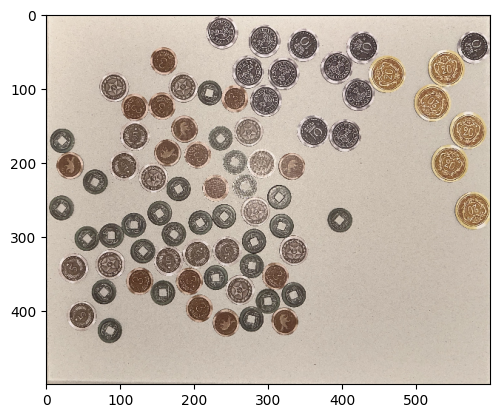

In [325]:
from skimage.transform import ProjectiveTransform, warp

points_current = np.array([list(left_upper),list(right_upper), list(right_lower), list(left_lower)])*4
points_desired = np.array([[0,500],[600,500],[600,0],[0,0]])

tform = ProjectiveTransform()
tform.estimate(points_desired, points_current)
# image_warped = warp(empty_image, tform)
# show(image_warped[:500,:600])
image_warped = warp(coin_image, tform)[:500,:600]
show(image_warped)

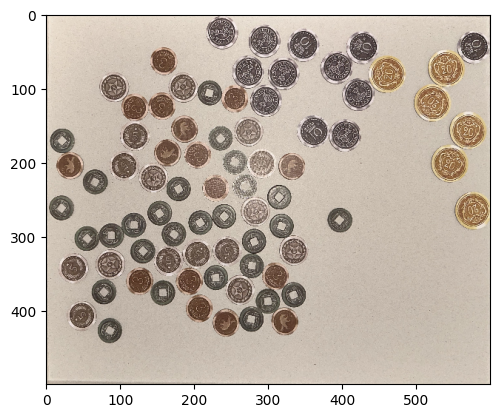

In [326]:
image_warped_255 = np.uint8(image_warped*255)
show(image_warped_255)


In [61]:
%matplotlib widget

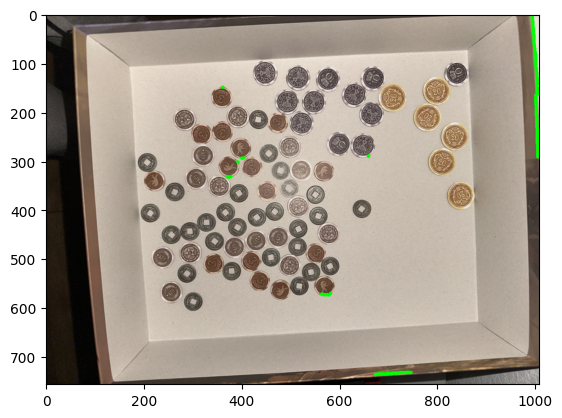

In [109]:
coin_image_cont = coin_image.copy()
contours_sorted = sorted(contours, key = cv.contourArea)
biggest_contours = contours_sorted[0:10]
cv.drawContours(coin_image_cont, biggest_contours, -1, (0,255,0), 5)
plt.imshow(coin_image_cont)
plt.show()

In [75]:
from ipywidgets import IntSlider, interact

In [233]:
# sld1 = IntSlider(value=17, min=0, max=50, step=1, continuous_update=False)
# sld2 = IntSlider(value=10, min=1, max=254, step=1, continuous_update=False)
# sld3 = IntSlider(value=100, min=1, max=254, step=1, continuous_update=False)


# def vary_canny_parameters(kernel_size, minVal, maxVal, img=coin_image):
#   img_smoothed = cv.GaussianBlur(img, ksize=(kernel_size,kernel_size),sigmaX=0,sigmaY=0)
#   show(img),show(cv.Canny(np.uint8(img_smoothed), minVal, maxVal), cmap='gray')

In [ ]:
interact(vary_canny_parameters, kernel_size=sld1, minVal=sld2, maxVal=sld3, img=image_warped_255);

In [ ]:
%matplotlib widget
show(image_warped_255)

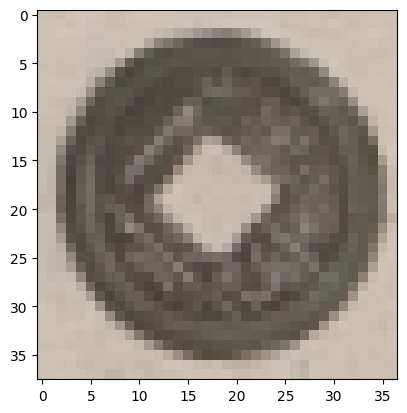

In [259]:
%matplotlib inline
show(image_warped_255[259:297,378:415])
template_1 = image_warped_255[259:297,378:415]


In [242]:
from skimage.feature import match_template

corr_skimage = match_template(image_warped_255, template_1, pad_input=True)

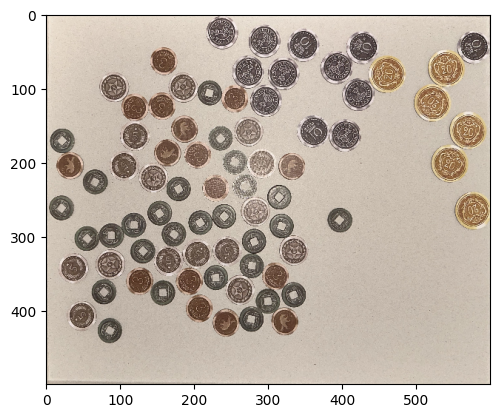

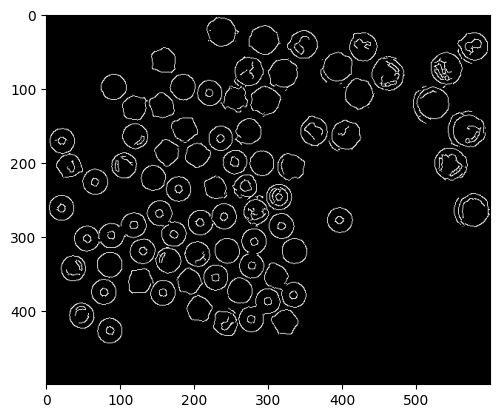

In [333]:
def vary_canny_parameters(kernel_size, minVal, maxVal, img=coin_image):
  img_smoothed = cv.GaussianBlur(img, ksize=(kernel_size,kernel_size),sigmaX=0,sigmaY=0)
  edges = cv.Canny(np.uint8(img_smoothed), minVal, maxVal)
  # edges_ = cv.morphologyEx(edges,cv.MORPH_CLOSE,np.ones((5,5),dtype=np.uint8))
  
  show(img),show(edges, cmap='gray')#,show(edges_, cmap='gray')
vary_canny_parameters(11, 15, 100, image_warped_255)

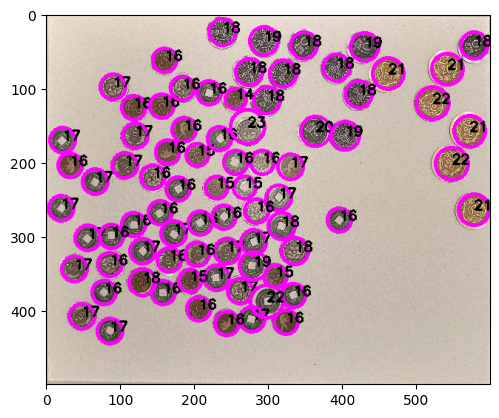

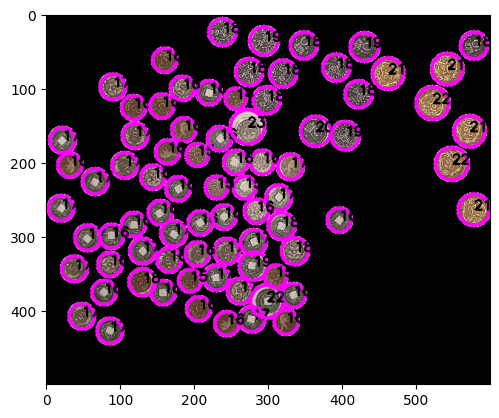

In [339]:
%matplotlib inline
# thresholded_uint8 = (thresholded*255).astype(np.uint8)
# show(thresholded_uint8, cmap='gray')
gray = cv.cvtColor(image_warped_255, cv.COLOR_RGB2GRAY)
blurred = cv.GaussianBlur(gray, ksize=(11,11),sigmaX=0,sigmaY=0)
circles = cv.HoughCircles(blurred, cv.HOUGH_GRADIENT, 1, 15,
                            param1=100, param2=15,
                            minRadius=12, maxRadius=25)
img_circles = image_warped_255.copy()
img_only_circles = np.zeros_like(image_warped_255)
if circles is not None:
  circles = np.uint16(np.around(circles))
  for i in circles[0, :]:
    center = (i[0], i[1])
    # circle center
    # cv.circle(img_circles, center, 1, (0, 100, 100), 5)
    # circle outline
    radius = i[2]
    cv.circle(img_circles, center, radius, (255, 0, 255), 3)
    cv.circle(img_only_circles, center, radius+3, (1, 1, 1), -1)
    cv.putText(img_circles, f'{radius}', center, cv.FONT_HERSHEY_SIMPLEX, 0.6,
               (0,0,0),2,)
show(img_circles)
# show(img_only_circles)
img_circles_masked = img_circles*img_only_circles
show(img_circles_masked)